In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc 
import imblearn
from imblearn.over_sampling import SMOTE

In [66]:
#read in the data and eliminate unnecessary index columns
df = pd.read_csv("final_no_pct_2000.csv")
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [67]:
# convert response to categorical variable
df['Playoff_Result'] = df['Playoff_Result'].astype('category')

In [68]:
# get the necessary columns
df_subset_rank = df.iloc[:,[1,2,30,32,4,8,19,20,22,25,11,13,16,63,69,57,53,44,10]].copy() 

In [69]:
df_subset_rank.columns

Index(['Playoff_Result', 'Year', 'O_Sc%', 'O_EXP', 'W', 'PD', 'OP_Yds',
       'OP_TD', 'O_NY/A', 'OR_TD', 'T_O_Yds', 'O_Y/P', 'O_1stD', 'D_EXP',
       'D_4D%', 'D_Y/A', 'D_NY/A', 'D_Y/P', 'SoS'],
      dtype='object')

# Fitting RF Models with Different Data Approaches:

In [70]:
# ranking offensive stats descending and defensive stats ascending
cols = df_subset_rank.columns
df_rank = df_subset_rank.copy()
for i in cols:
    if i == 'Playoff_Result' or i == 'Year' or i == 'SoS': # don't rank SoS?
        continue
    else:
        if i in ['O_Sc%', 'O_EXP', 'W', 'PD', 'OP_Yds', 'O_NY/A', 'O_3D%', 'OR_TD', 'T_O_Yds', 'O_Y/P', 'O_1stD']:
            df_rank[i] = df_rank.groupby(['Year'])[i].rank(ascending=False)
        else:
            df_rank[i] = df_rank.groupby(['Year'])[i].rank(ascending=True)

In [71]:
# ranking all stats descending
cols = df_subset_rank.columns
df_rank = df_subset_rank.copy()
for i in cols:
    if i == 'Playoff_Result' or i == 'Year':
        continue
    else:
        df_rank[i] = df_rank.groupby(['Year'])[i].rank(ascending=False)

In [72]:
# ranking all stats ascending
cols = df_subset_rank.columns
df_rank = df_subset_rank.copy()
for i in cols:
    if i == 'Playoff_Result' or i == 'Year':
        continue
    else:
        df_rank[i] = df_rank.groupby(['Year'])[i].rank(ascending=True)

In [73]:
# use both the data and the ranks (descending)
cols = df_subset_rank.columns
df_rank = df_subset_rank.copy()
for i in cols:
    if i == 'Playoff_Result' or i == 'Year': # don't rank SoS?
        continue
    else:
        df_rank[i + "_rank"] = df_rank.groupby(['Year'])[i].rank(ascending=False)

In [74]:
# use both the data and the descending offensive ranks and ascending defensive ranks
cols = df_subset_rank.columns
df_rank = df_subset_rank.copy()
for i in cols:
    if i == 'Playoff_Result' or i == 'Year' or i == 'SoS': # don't rank SoS?
        continue
    else: 
        if i in ['O_Sc%', 'O_EXP', 'W', 'PD', 'OP_Yds', 'O_NY/A', 'O_3D%', 'OR_TD', 'T_O_Yds', 'O_Y/P', 'O_1stD']:
            df_rank[i + "_rank"] = df_rank.groupby(['Year'])[i].rank(ascending=False)
        else:
            df_rank[i + "_rank"] = df_rank.groupby(['Year'])[i].rank(ascending=True)

In [75]:
# separate the response
X = df_rank.drop(['Playoff_Result'], axis=1)
y = df_rank['Playoff_Result']

In [76]:
# run this if using just the data and not ranks
X = df_subset_rank.drop(['Playoff_Result'], axis=1)
y = df_subset_rank['Playoff_Result']

In [77]:
# find the best tuning parameters for the data -- use roc_auc_ovr as performance metric
clf = DecisionTreeClassifier(random_state=100)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

# use 5-fold CV to select the optimal tuning parameter
kfoldcv_accuracy = np.zeros(ccp_alphas.shape[0])
kfold = KFold(n_splits = 5, random_state=100, shuffle=True)
for i in range(ccp_alphas.shape[0]):
    model = RandomForestClassifier(random_state=100, ccp_alpha= ccp_alphas[i])
    kfoldcv_accuracy[i] = np.mean(cross_val_score(model, X, y, cv = kfold, scoring='roc_auc_ovr'))

In [79]:
# find the tuning parameter with the best performance
best_ind = np.argmax(kfoldcv_accuracy)
print(best_ind) 
best = ccp_alphas[best_ind]
print(best)

72
0.047223697414479404


In [80]:
# Use GridSearchCv to tune other hyperparameters

param_grid = {'max_depth': range(3,15), 'max_features':['log2','sqrt'], 'ccp_alpha':[0.0, best]}

#Initialize the classifier
rf_clf = GridSearchCV(RandomForestClassifier(random_state=100), param_grid, 
                      scoring='roc_auc_ovr',refit=False, n_jobs=-1)

In [81]:
x = rf_clf.fit(X, y)

print(x.best_params_, x.best_score_)

{'ccp_alpha': 0.0, 'max_depth': 9, 'max_features': 'log2'} 0.6850077303787334


In [82]:
# store the optimal values for the hyperparameters
alpha = x.best_params_.get('ccp_alpha')
md = x.best_params_.get('max_depth')
mf = x.best_params_.get('max_features')

In [83]:
# this function fits a random forest classification model with the specified hyperparameters to the data and returns
# a tuple containing the test error and auc score
def fit_model(train, test, alpha, md, mf):
    # separate the response
    X_train = train.drop(['Playoff_Result'], axis=1)
    X_test = test.drop(['Playoff_Result'], axis=1)
    y_train = train['Playoff_Result']
    y_test = test['Playoff_Result']
    
    # fit model with best parameters
    final_cl_rf = RandomForestClassifier(ccp_alpha=alpha, max_depth=md, max_features=mf, random_state=100)
    final_cl_rf.fit(X_train, y_train)
    
    # get test error
    y_pred = final_cl_rf.predict(X_test)
    te = np.mean(y_pred != y_test)
    
    # get auc score
    y_pred_prob = final_cl_rf.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    
    return [te, auc]
    

In [84]:
years = list(range(2000,2023))
test_errors = list()
aucs = list()


In [85]:
# for each year, hold that year out as a test set and use the data for remaining years as training
# fit a random forest classification model to the data (using each year as test set)
# and store the test error and auc score for each model
for year in years:
    train = df_rank[df_rank['Year']!=year]
    test =  df_rank[df_rank['Year']==year]
    test_errors.append(fit_model(train, test, alpha, md, mf)[0])
    aucs.append(fit_model(train, test, alpha, md, mf)[1])

In [86]:
# get the test errors
test_errors

[0.8333333333333334,
 0.6666666666666666,
 0.5833333333333334,
 0.5833333333333334,
 0.75,
 0.5833333333333334,
 0.5833333333333334,
 0.5833333333333334,
 0.3333333333333333,
 0.6666666666666666,
 0.5,
 0.5,
 0.5,
 0.6666666666666666,
 0.4166666666666667,
 0.6666666666666666,
 0.5833333333333334,
 0.5833333333333334,
 0.6666666666666666,
 0.6666666666666666,
 0.35714285714285715,
 0.7857142857142857,
 0.5]

In [87]:
# get the aucs
aucs

[0.5045454545454545,
 0.55375,
 0.8493181818181817,
 0.692840909090909,
 0.7036363636363636,
 0.7668181818181818,
 0.730909090909091,
 0.59375,
 0.7960227272727273,
 0.5818181818181818,
 0.6259090909090909,
 0.7232954545454546,
 0.6831818181818182,
 0.7248863636363636,
 0.7353409090909091,
 0.6939772727272728,
 0.7129545454545454,
 0.8012499999999999,
 0.6146590909090909,
 0.6647727272727273,
 0.8483974358974358,
 0.400128205128205,
 0.8717948717948717]

In [88]:
# get the averages -- use this as a summary performance metric
avg_te = np.mean(test_errors)
avg_auc = np.mean(aucs)

In [89]:
avg_te

0.5895445134575571

In [90]:
avg_auc

0.6901720381068207

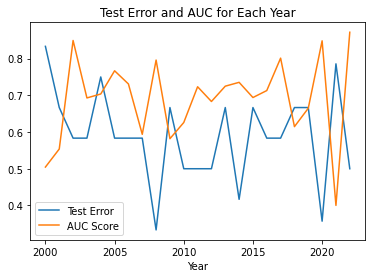

In [91]:
# plot the test errors and aucs against year
plt.plot(years, test_errors, label='Test Error')
plt.plot(years, aucs, label='AUC Score')
plt.legend()
plt.title('Test Error and AUC for Each Year')
plt.xlabel('Year')
plt.show();

# Comparing Results:

In [95]:
# when ranking offensive stats descending and defensive stats ascending we get: avg_te = 0.5828, avg_auc = 0.6720
# when ranking all stats descending we get: avg_te = 0.5911, avg_auc = 0.6664 (with scoring=roc_auc_ovr)
# when ranking all stats ascending we get: avg_te = 0.6014, avg_auc = 0.6627 (with scoring=roc_auc_ovr)
# when using both the data and the (descending) ranks we get: avg_te = 0.5595, avg_auc = 0.6974 (with scoring=roc_auc_ovr)
# when using both the data and the descending offensive ranks and ascending defensive ranks we get: 
#                                                                               avg_te = 0.5766, avg_auc = 0.6802
# when using just the raw data and not the ranks we get avg_te = 0.60004 and avg_auc = 0.6859 (with scoring=roc_auc_ovr)

We found that the best-performing model used both the raw data and the descending ranks. This model produced an average test error of $0.5595$ and an average AUC score of $0.6974$.